In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [97]:
# Check for missing values
awards_players = pd.read_csv('awards_players.csv')
coaches = pd.read_csv('coaches.csv')
players = pd.read_csv('players.csv')
players_teams = pd.read_csv('players_teams.csv')
series_post = pd.read_csv('series_post.csv')
teams = pd.read_csv('teams.csv')
teams_post = pd.read_csv('teams_post.csv')

In [98]:
# Drop unnecessary columns only after all calculations are done
players.drop(['firstseason', 'lastseason','deathDate','collegeOther'], axis=1, inplace=True)
players.head()

,bioID,pos,height,weight,college,birthDate
0,abrahta01w,C,74.0,190,George Washington,1975-09-27
1,abrossv01w,F,74.0,169,Connecticut,1980-07-09
2,adairje01w,C,76.0,197,George Washington,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,1981-05-24


In [99]:
# Assuming the uploaded CSV is already loaded into a dataframe named `teams`
# 1. Win Ratios
teams['win_ratio'] = teams['won'] / teams['GP']
teams.drop(['won'], axis=1, inplace=True)

teams['home_win_ratio'] = teams['homeW'] / (teams['homeW'] + teams['homeL'])
teams.drop(['homeW', 'homeL'], axis=1, inplace=True)

teams['away_win_ratio'] = teams['awayW'] / (teams['awayW'] + teams['awayL'])
teams.drop(['awayW', 'awayL'], axis=1, inplace=True)

teams['conf_win_ratio'] = teams['confW'] / (teams['confW'] + teams['confL'])
teams.drop(['confW', 'confL'], axis=1, inplace=True)

# 2. Scoring Efficiency
teams['off_efficiency'] = teams['o_pts'] / (teams['o_fga'] + teams['o_fta'])
teams.drop(['o_pts', 'o_fga', 'o_fta'], axis=1, inplace=True)

teams['def_efficiency'] = teams['d_pts'] / (teams['d_fga'] + teams['d_fta'])
teams.drop(['d_pts', 'd_fga', 'd_fta'], axis=1, inplace=True)

# 3. Rebounding Metrics
teams['off_reb_percentage'] = teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb'])
teams.drop(['o_oreb', 'd_dreb'], axis=1, inplace=True)

teams['def_reb_percentage'] = teams['o_dreb'] / (teams['o_dreb'] + teams['d_oreb'])
teams.drop(['o_dreb', 'd_oreb'], axis=1, inplace=True)

# 4. Turnover Ratio
teams['to_ratio'] = teams['o_to'] / teams['GP']

# Assuming the dataframe is named `teams`

# 1. Scoring Contribution
teams['fgm_contribution'] = teams['o_fgm'] * 2 + teams['o_3pm'] * 3
teams['ftm_contribution'] = teams['o_ftm']  # Free throws worth 1 point each
teams['three_point_ratio'] = teams['o_3pm'] / teams['o_3pa']

# Drop the columns used above
teams.drop(['o_fgm', 'o_3pm', 'o_ftm', 'o_3pa'], axis=1, inplace=True)

# 3. Assist-to-Turnover Ratios
teams['off_ast_to_ratio'] = teams['o_asts'] / teams['o_to']
teams['def_ast_to_ratio'] = teams['d_asts'] / teams['d_to']

# Drop assist and turnover columns
teams.drop(['o_asts', 'd_asts', 'o_to', 'd_to'], axis=1, inplace=True)

# 4. Steal and Block Ratios
teams['off_steal_ratio'] = teams['o_stl'] / teams['GP']
teams['off_block_ratio'] = teams['o_blk'] / teams['GP']
teams['def_steal_ratio'] = teams['d_stl'] / teams['GP']
teams['def_block_ratio'] = teams['d_blk'] / teams['GP']

# Drop the corresponding columns
teams.drop(['o_stl', 'o_blk', 'd_stl', 'd_blk'], axis=1, inplace=True)

# 5. Efficiency per Minute
teams['efficiency_per_min'] = (teams['win_ratio'] + teams['off_efficiency'] - teams['def_efficiency']) / teams['min']

# Drop the `min` column as it's been used
teams.drop(['min'], axis=1, inplace=True)

# 6. Points allowed vs. Points scored
teams['points_diff'] = (teams['win_ratio'] * teams['GP'] * teams['off_efficiency']) - (teams['def_efficiency'] * teams['GP'] * teams['win_ratio'])

teams['playoff'] = teams['rank'] <= 4

# Calculer le pourcentage d'années où le rang est <= 4 pour chaque équipe
teams['playoffratio'] = teams.groupby('tmID')['playoff'].transform('mean')
teams['meanrank'] = teams.groupby('tmID')['rank'].transform('mean')

# Drop any other residual columns
# DivID, seeded,'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'  are always nan or 0
# arena and name are irrelevant
# lgID is alaway the same WNBA
# 'firstRound','semis', 'finals' to prevent future data leakage
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB','d_fgm', 'd_ftm', 'd_3pm', 'd_3pa', 'o_reb', 'd_reb', 'o_pf', 'd_pf', 'lost','divID','arena','lgID','name','seeded','firstRound','semis', 'finals'], axis=1, inplace=True)


In [100]:
teams.head()

,year,tmID,franchID,confID,rank,playoff,GP,attend,win_ratio,home_win_ratio,away_win_ratio,conf_win_ratio,off_efficiency,def_efficiency,off_reb_percentage,def_reb_percentage,to_ratio,fgm_contribution,ftm_contribution,three_point_ratio,off_ast_to_ratio,def_ast_to_ratio,off_steal_ratio,off_block_ratio,def_steal_ratio,def_block_ratio,efficiency_per_min,points_diff,playoffratio,meanrank
0,9,ATL,ATL,EA,7,False,34,141379,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595,0.500000,4.500000
1,10,ATL,ATL,EA,2,True,34,120737,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057,0.500000,4.500000
2,1,CHA,CHA,EA,8,False,32,90963,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302,0.428571,4.714286
3,2,CHA,CHA,EA,4,True,32,105525,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421,0.428571,4.714286
4,3,CHA,CHA,EA,2,True,32,106670,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113,0.428571,4.714286


In [101]:
# Use `teams_post` dataframe for augmentation
# 1. Win Ratio
teams_post['win_ratio_post'] = teams_post['W'] / (teams_post['W'] + teams_post['L'])

# 2. Total Games Played
teams_post['total_games_post'] = teams_post['W'] + teams_post['L']

# 3. Winning Margin
teams_post['win_margin_post'] = teams_post['W'] - teams_post['L']

# Drop the columns used for calculations
teams_post.drop(['W', 'L','lgID'], axis=1, inplace=True)
teams_post.fillna(0, inplace=True)

In [102]:
# Use `players_teams` dataframe for augmentation

# 1. Per-Game Metrics
players_teams['points_per_game'] = players_teams['points'] / players_teams['GP']
players_teams['rebounds_per_game'] = (players_teams['oRebounds'] + players_teams['dRebounds']) / players_teams['GP']
players_teams['assists_per_game'] = players_teams['assists'] / players_teams['GP']
players_teams['steals_per_game'] = players_teams['steals'] / players_teams['GP']
players_teams['blocks_per_game'] = players_teams['blocks'] / players_teams['GP']

# Drop columns used for the above calculations
players_teams.drop(['points', 'oRebounds', 'dRebounds', 'assists', 'steals', 'blocks'], axis=1, inplace=True)

# 2. Efficiency Ratios
players_teams['assist_to_turnover_ratio'] = players_teams['assists_per_game'] / players_teams['turnovers']
players_teams['points_per_minute'] = players_teams['points_per_game'] / players_teams['minutes']

# Drop the `turnovers` column
players_teams.drop(['turnovers'], axis=1, inplace=True)

# 3. Postseason Metrics (mirror regular season)
players_teams['post_points_per_game'] = players_teams['PostPoints'] / players_teams['PostGP']
players_teams['post_rebounds_per_game'] = (players_teams['PostoRebounds'] + players_teams['PostdRebounds']) / players_teams['PostGP']
players_teams['post_assists_per_game'] = players_teams['PostAssists'] / players_teams['PostGP']

# Drop the postseason columns used
players_teams.drop(['PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostAssists'], axis=1, inplace=True)

# 4. Player Impact Score
players_teams['player_impact_score'] = (players_teams['points_per_game'] + players_teams['rebounds_per_game'] +
                                        players_teams['assists_per_game'] + players_teams['steals_per_game'] * 2)

# 1. Shooting Efficiency Metrics
players_teams['fg_percentage'] = players_teams['fgMade'] / players_teams['fgAttempted']
players_teams['ft_percentage'] = players_teams['ftMade'] / players_teams['ftAttempted']
players_teams['three_point_percentage'] = players_teams['threeMade'] / players_teams['threeAttempted']

# Drop columns used above
players_teams.drop(['fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade'], axis=1, inplace=True)

# 2. Fouls and Discipline Metrics
# Use `GP` before dropping it
players_teams['foul_rate'] = players_teams['PF'] / players_teams['GP']
players_teams['disqualification_rate'] = players_teams['dq'] / players_teams['GP']

# Drop columns used above
players_teams.drop(['PF', 'dq'], axis=1, inplace=True)

# 3. Postseason Shooting Efficiency
players_teams['post_fg_percentage'] = players_teams['PostfgMade'] / players_teams['PostfgAttempted']
players_teams['post_ft_percentage'] = players_teams['PostftMade'] / players_teams['PostftAttempted']
players_teams['post_three_point_percentage'] = players_teams['PostthreeMade'] / players_teams['PostthreeAttempted']

# Drop postseason shooting columns used
players_teams.drop(['PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
                    'PostthreeAttempted', 'PostthreeMade'], axis=1, inplace=True)

# 4. Postseason Impact Metrics
# Use `PostGP` before dropping it
players_teams['post_rebounds_per_game'] = players_teams['PostRebounds'] / players_teams['PostGP']
players_teams['post_steals_per_game'] = players_teams['PostSteals'] / players_teams['PostGP']
players_teams['post_blocks_per_game'] = players_teams['PostBlocks'] / players_teams['PostGP']
players_teams['post_turnover_rate'] = players_teams['PostTurnovers'] / players_teams['PostGP']
players_teams['post_foul_rate'] = players_teams['PostPF'] / players_teams['PostGP']
players_teams['post_disqualification_rate'] = players_teams['PostDQ'] / players_teams['PostGP']
#players_teams['pplayoff'] = players_teams['PostGP'] > 0

# Calculer le pourcentage d'années où le rang est <= 4 pour chaque équipe
#players_teams['pplayoffratio'] = players_teams.groupby('playerID')['pplayoff'].transform('mean')

# Drop the GP columns only after they have been used
players_teams.drop(['PostGP', 'minutes', 'GP', 'GS', 'PostRebounds', 'PostSteals', 'PostBlocks',
                    'PostTurnovers', 'PostPF', 'PostDQ', 'PostGS', 'PostMinutes','lgID'], axis=1, inplace=True)

players_teams.fillna(0, inplace=True)

In [103]:
players_teams.head()

,playerID,year,stint,tmID,rebounds,points_per_game,rebounds_per_game,assists_per_game,steals_per_game,blocks_per_game,assist_to_turnover_ratio,points_per_minute,post_points_per_game,post_rebounds_per_game,post_assists_per_game,player_impact_score,fg_percentage,ft_percentage,three_point_percentage,foul_rate,disqualification_rate,post_fg_percentage,post_ft_percentage,post_three_point_percentage,post_steals_per_game,post_blocks_per_game,post_turnover_rate,post_foul_rate,post_disqualification_rate
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,0.023982,0.015594,0.000000,0.000000,0.000000,25.153846,0.389078,0.727273,0.250000,2.692308,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,0.024155,0.014447,0.000000,0.000000,0.000000,22.370370,0.376582,0.482759,0.333333,2.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,0.030370,0.013384,7.666667,1.666667,1.333333,20.966667,0.392982,0.704082,0.304878,2.633333,0.000000,0.272727,1.0,0.428571,1.333333,0.333333,2.666667,2.666667,0.0
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,0.047569,0.014364,10.000000,4.500000,1.500000,14.772727,0.352518,0.608696,0.377358,1.909091,0.000000,0.347826,0.5,0.250000,0.500000,1.000000,1.500000,3.500000,0.0
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,0.024194,0.012621,0.000000,0.000000,0.000000,18.290323,0.394928,0.726027,0.402439,2.774194,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [104]:
# Use `coaches` dataframe for augmentation

# 1. Win Ratios
coaches['win_ratio'] = coaches['won'] / (coaches['won'] + coaches['lost'])
coaches['post_win_ratio'] = coaches['post_wins'] / (coaches['post_wins'] + coaches['post_losses'])

# 2. Total Games Coached
coaches['total_games'] = coaches['won'] + coaches['lost']
coaches['total_post_games'] = coaches['post_wins'] + coaches['post_losses']

# Drop the original columns used for calculations
coaches.drop(['won', 'lost', 'post_wins', 'post_losses','lgID'], axis=1, inplace=True)
coaches.fillna(0, inplace=True)

coaches['playoff'] = coaches['total_post_games'] > 0

# Calculer le pourcentage d'années où le rang est <= 4 pour chaque équipe
coaches['playoffratio'] = coaches.groupby('coachID')['playoff'].transform('mean')

In [105]:
coaches.head()

,coachID,year,tmID,stint,win_ratio,post_win_ratio,total_games,total_post_games,playoff,playoffratio
0,adamsmi01w,5,WAS,0,0.500000,0.333333,34,3,True,1.0
1,adubari99w,1,NYL,0,0.625000,0.571429,32,7,True,0.5
2,adubari99w,2,NYL,0,0.656250,0.500000,32,6,True,0.5
3,adubari99w,3,NYL,0,0.562500,0.500000,32,8,True,0.5
4,adubari99w,4,NYL,0,0.470588,0.000000,34,0,False,0.5


In [106]:
awards_players['award'].unique()

array(['All-Star Game Most Valuable Player', 'Coach of the Year',
       'Defensive Player of the Year', 'Kim Perrot Sportsmanship',
       'Kim Perrot Sportsmanship Award', 'Most Improved Player',
       'Most Valuable Player', 'Rookie of the Year',
       'Sixth Woman of the Year', 'WNBA Finals Most Valuable Player',
       'WNBA All-Decade Team', 'WNBA All Decade Team Honorable Mention'],
      dtype=object)

In [107]:
awards_players.loc[awards_players['award'] == 'Kim Perrot Sportsmanship', 'award'] = 'Kim Perrot Sportsmanship Award'

In [108]:
# Define a mapping dictionary for awards and their respective points
award_points_mapping = {
    'Kim Perrot Sportsmanship Award': 0,
    'Most Valuable Player': 15,
    'WNBA Finals Most Valuable Player': 13,
    'WNBA All-Decade Team': 12,
    'All-Star Game Most Valuable Player': 10,
    'Coach of the Year': 9,
    'Defensive Player of the Year': 8,
    'WNBA All Decade Team Honorable Mention': 7,
    'Sixth Woman of the Year': 6,
    'Most Improved Player': 5,
    'Rookie of the Year': 4
}

# Map the 'award' column to the points using the mapping dictionary
awards_players['awardPoints'] = awards_players['award'].map(award_points_mapping)
awards_players.drop(['award'], axis=1, inplace=True)


In [109]:
awards_players.head()

,playerID,year,lgID,awardPoints
0,thompti01w,1,WNBA,10
1,leslili01w,2,WNBA,10
2,leslili01w,3,WNBA,10
3,teaslni01w,4,WNBA,10
4,swoopsh01w,6,WNBA,10


In [110]:
# Correct the prefix handling and ensure 'playerID' is retained correctly

coaches_prefixed = coaches.add_prefix('coaches_')
players_prefixed = players.add_prefix('players_')
players_teams_prefixed = players_teams.add_prefix('players_teams_')
teams_prefixed = teams.add_prefix('teams_')
teams_post_prefixed = teams_post.add_prefix('teams_post_')
awards_players_prefixed = awards_players.add_prefix('awards_players_')

# Remove the prefix from columns used for merging
teams_prefixed.rename(columns={'teams_tmID': 'tmID', 'teams_year': 'year'}, inplace=True)
teams_post_prefixed.rename(columns={'teams_post_tmID': 'tmID', 'teams_post_year': 'year'}, inplace=True)
coaches_prefixed.rename(columns={'coaches_tmID': 'tmID', 'coaches_year': 'year'}, inplace=True)
players_teams_prefixed.rename(columns={'players_teams_tmID': 'tmID', 'players_teams_year': 'year', 'players_teams_playerID': 'playerID'}, inplace=True)
awards_players_prefixed.rename(columns={'awards_players_playerID': 'playerID', 'awards_players_year': 'year'}, inplace=True)

# Step 2: Merge teams with teams_post
team_data = pd.merge(teams_prefixed, teams_post_prefixed, how='left', on=['tmID', 'year'])

# Step 3: Merge players with players_teams
players_prefixed.rename(columns={'players_bioID': 'playerID'}, inplace=True)
players_prefixed.rename(columns={'players_playerID': 'playerID'}, inplace=True)

# Step 3: Merge players with players_teams correctly using the right columns
players_teams_combined = pd.merge(players_teams_prefixed, players_prefixed, how='left', on='playerID')

def classify_position(position):
    interior = ['C', 'CF', 'FC']
    if position in interior:
        return 'interior'
    else:
        return 'exterior'

players_teams_combined['players_pos'] = players_teams_combined['players_pos'].apply(classify_position)

players_teams_combined['players_birthDate'] = pd.to_datetime(players_teams_combined['players_birthDate'])

players_teams_combined['offset'] = players_teams_combined['players_birthDate'].dt.year - 1978

result = players_teams_combined.groupby(['tmID', 'year']).agg(
    num_interior=('players_pos', lambda x: (x == 'interior').sum()),
    num_exterior=('players_pos', lambda x: (x == 'exterior').sum())
).reset_index()  #this table result contain tmid year the number of interior player and number of exterior player


# Continue with the rest of the merge steps as defined
# Step 4: Aggregate player stats by team
player_stats_by_team = players_teams_combined.groupby(['tmID', 'year']).agg({
    'players_teams_points_per_game': 'sum',
    'players_teams_rebounds_per_game': 'sum',
    'offset':'mean'#,'players_teams_pplayoffratio': 'max'
}).reset_index()

# Step 5: Merge team_data with player_stats_by_team
team_data = pd.merge(team_data, player_stats_by_team, how='left', on=['tmID', 'year'])
team_data = pd.merge(team_data, result, how='left', on=['tmID', 'year'])
# Step 6.0 Aggregate coaches stats by teal
coaches_agg = coaches_prefixed.groupby(['tmID', 'year']).agg({
    'coaches_stint': 'sum',                   # Somme des périodes de coaching (passages)
    'coaches_win_ratio': 'mean',              # Moyenne du ratio de victoires
    'coaches_post_win_ratio': 'mean',         # Moyenne du ratio de victoires en playoffs
    'coaches_total_games': 'sum',             # Somme du nombre total de matchs joués
    'coaches_total_post_games': 'sum',       # Somme du nombre total de matchs en playoffs
    'coaches_playoffratio' : 'mean'
}).reset_index()

# Merge team_data with coaches
team_data = pd.merge(team_data, coaches_agg, how='left', on=['tmID', 'year'])

# Step 6: Merge team_data with coaches
#team_data = pd.merge(team_data, coaches_prefixed, how='left', on=['tmID', 'year']) old version dont use it

# Step 7: Merge awards_players with players_teams
awards_with_teams = pd.merge(awards_players_prefixed, players_teams_prefixed, how='left', on=['playerID', 'year'])

# Step 8: Aggregate awards by team
awards_by_team = awards_with_teams.groupby(['tmID', 'year']).agg({
    'awards_players_awardPoints': 'sum'
}).reset_index()

# Step 9: Merge awards_by_team with team_data
team_data = pd.merge(team_data, awards_by_team, how='left', on=['tmID', 'year'])

# Step 10: Fill missing values in num_awards and other columns
team_data['awards_players_awardPoints'].fillna(0, inplace=True)
team_data.fillna(0, inplace=True)

<ipython-input-110-72378622008e>:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_data['awards_players_awardPoints'].fillna(0, inplace=True)


In [111]:
players_teams_combined.head()

,playerID,year,players_teams_stint,tmID,players_teams_rebounds,players_teams_points_per_game,players_teams_rebounds_per_game,players_teams_assists_per_game,players_teams_steals_per_game,players_teams_blocks_per_game,players_teams_assist_to_turnover_ratio,players_teams_points_per_minute,players_teams_post_points_per_game,players_teams_post_rebounds_per_game,players_teams_post_assists_per_game,players_teams_player_impact_score,players_teams_fg_percentage,players_teams_ft_percentage,players_teams_three_point_percentage,players_teams_foul_rate,players_teams_disqualification_rate,players_teams_post_fg_percentage,players_teams_post_ft_percentage,players_teams_post_three_point_percentage,players_teams_post_steals_per_game,players_teams_post_blocks_per_game,players_teams_post_turnover_rate,players_teams_post_foul_rate,players_teams_post_disqualification_rate,players_pos,players_height,players_weight,players_college,players_birthDate,offset
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,0.023982,0.015594,0.000000,0.000000,0.000000,25.153846,0.389078,0.727273,0.250000,2.692308,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,0.024155,0.014447,0.000000,0.000000,0.000000,22.370370,0.376582,0.482759,0.333333,2.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,0.030370,0.013384,7.666667,1.666667,1.333333,20.966667,0.392982,0.704082,0.304878,2.633333,0.000000,0.272727,1.0,0.428571,1.333333,0.333333,2.666667,2.666667,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,0.047569,0.014364,10.000000,4.500000,1.500000,14.772727,0.352518,0.608696,0.377358,1.909091,0.000000,0.347826,0.5,0.250000,0.500000,1.000000,1.500000,3.500000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,0.024194,0.012621,0.000000,0.000000,0.000000,18.290323,0.394928,0.726027,0.402439,2.774194,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2


In [112]:
players_teams_combined.head()

,playerID,year,players_teams_stint,tmID,players_teams_rebounds,players_teams_points_per_game,players_teams_rebounds_per_game,players_teams_assists_per_game,players_teams_steals_per_game,players_teams_blocks_per_game,players_teams_assist_to_turnover_ratio,players_teams_points_per_minute,players_teams_post_points_per_game,players_teams_post_rebounds_per_game,players_teams_post_assists_per_game,players_teams_player_impact_score,players_teams_fg_percentage,players_teams_ft_percentage,players_teams_three_point_percentage,players_teams_foul_rate,players_teams_disqualification_rate,players_teams_post_fg_percentage,players_teams_post_ft_percentage,players_teams_post_three_point_percentage,players_teams_post_steals_per_game,players_teams_post_blocks_per_game,players_teams_post_turnover_rate,players_teams_post_foul_rate,players_teams_post_disqualification_rate,players_pos,players_height,players_weight,players_college,players_birthDate,offset
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,0.023982,0.015594,0.000000,0.000000,0.000000,25.153846,0.389078,0.727273,0.250000,2.692308,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,0.024155,0.014447,0.000000,0.000000,0.000000,22.370370,0.376582,0.482759,0.333333,2.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,0.030370,0.013384,7.666667,1.666667,1.333333,20.966667,0.392982,0.704082,0.304878,2.633333,0.000000,0.272727,1.0,0.428571,1.333333,0.333333,2.666667,2.666667,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,0.047569,0.014364,10.000000,4.500000,1.500000,14.772727,0.352518,0.608696,0.377358,1.909091,0.000000,0.347826,0.5,0.250000,0.500000,1.000000,1.500000,3.500000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,0.024194,0.012621,0.000000,0.000000,0.000000,18.290323,0.394928,0.726027,0.402439,2.774194,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2


In [113]:
team_data.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,teams_away_win_ratio,teams_conf_win_ratio,teams_off_efficiency,teams_def_efficiency,teams_off_reb_percentage,teams_def_reb_percentage,teams_to_ratio,teams_fgm_contribution,teams_ftm_contribution,teams_three_point_ratio,teams_off_ast_to_ratio,teams_def_ast_to_ratio,teams_off_steal_ratio,teams_off_block_ratio,teams_def_steal_ratio,teams_def_block_ratio,teams_efficiency_per_min,teams_points_diff,teams_playoffratio,teams_meanrank,teams_post_win_ratio_post,teams_post_total_games_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,offset,num_interior,num_exterior,coaches_stint,coaches_win_ratio,coaches_post_win_ratio,coaches_total_games,coaches_total_post_games,coaches_playoffratio,awards_players_awardPoints
0,9,ATL,ATL,EA,7,False,34,141379,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595,0.500000,4.500000,0.0,0.0,0.0,90.280886,42.711812,4.428571,1,13,0,0.117647,0.0,34,0,0.500000,0.0
1,10,ATL,ATL,EA,2,True,34,120737,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057,0.500000,4.500000,0.0,2.0,-2.0,95.379269,41.553204,4.384615,1,12,0,0.529412,0.0,34,2,0.500000,4.0
2,1,CHA,CHA,EA,8,False,32,90963,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302,0.428571,4.714286,0.0,0.0,0.0,83.889925,34.508183,-4.538462,2,11,0,0.250000,0.0,32,0,0.000000,0.0
3,2,CHA,CHA,EA,4,True,32,105525,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421,0.428571,4.714286,0.5,8.0,0.0,68.969460,34.470022,-3.750000,2,10,0,0.562500,0.5,32,8,0.666667,0.0
4,3,CHA,CHA,EA,2,True,32,106670,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113,0.428571,4.714286,0.0,2.0,-2.0,74.023695,32.655009,-3.769231,3,10,0,0.562500,0.0,32,2,0.666667,0.0


In [114]:
team_data.columns

Index(['year', 'tmID', 'teams_franchID', 'teams_confID', 'teams_rank',
       'teams_playoff', 'teams_GP', 'teams_attend', 'teams_win_ratio',
       'teams_home_win_ratio', 'teams_away_win_ratio', 'teams_conf_win_ratio',
       'teams_off_efficiency', 'teams_def_efficiency',
       'teams_off_reb_percentage', 'teams_def_reb_percentage',
       'teams_to_ratio', 'teams_fgm_contribution', 'teams_ftm_contribution',
       'teams_three_point_ratio', 'teams_off_ast_to_ratio',
       'teams_def_ast_to_ratio', 'teams_off_steal_ratio',
       'teams_off_block_ratio', 'teams_def_steal_ratio',
       'teams_def_block_ratio', 'teams_efficiency_per_min',
       'teams_points_diff', 'teams_playoffratio', 'teams_meanrank',
       'teams_post_win_ratio_post', 'teams_post_total_games_post',
       'teams_post_win_margin_post', 'players_teams_points_per_game',
       'players_teams_rebounds_per_game', 'offset', 'num_interior',
       'num_exterior', 'coaches_stint', 'coaches_win_ratio',
       'coaches

In [115]:
team_data_no_str = team_data.drop(['tmID', 'teams_franchID', 'teams_confID','teams_playoff'], axis=1)

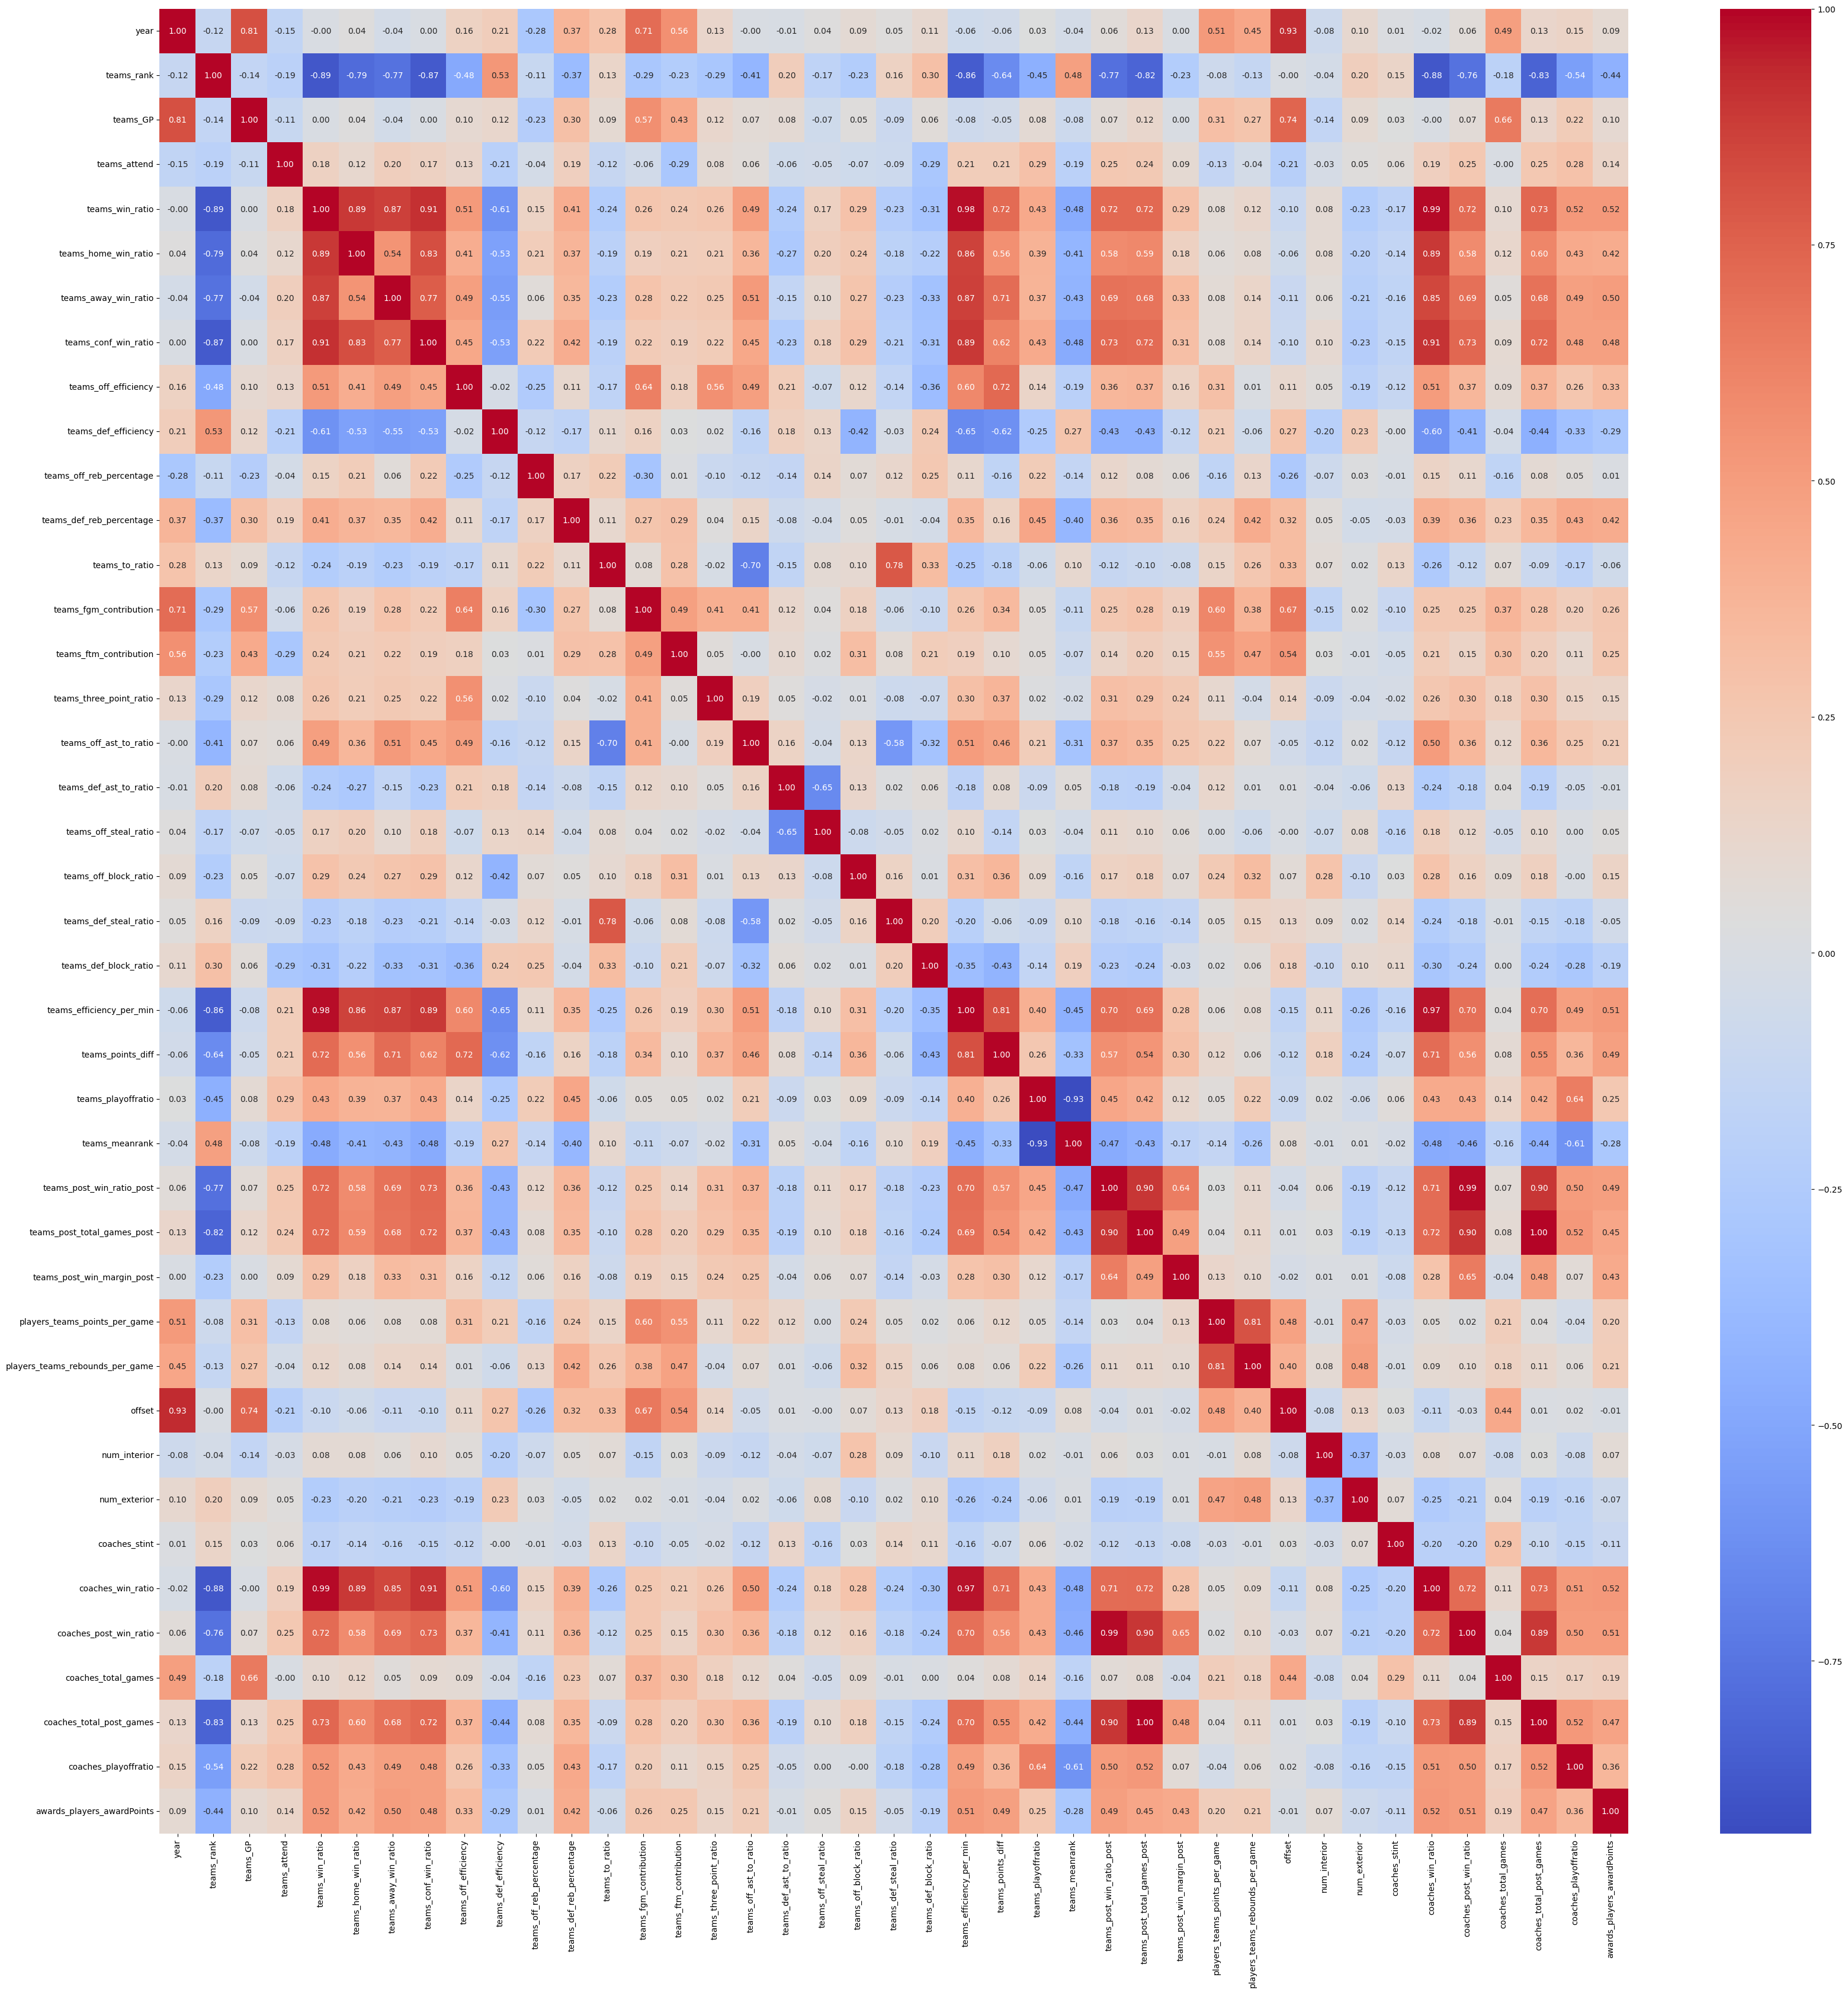

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = team_data_no_str.corr()

# Save the correlation matrix as a CSV file
corr_matrix.to_csv("correlation_matrix.csv")

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [117]:
# Find columns with high correlation (|correlation| >= 0.75) to determine which to drop
columns_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.90:
            # Drop the second column in the highly correlated pair
            col2 = corr_matrix.columns[j]
            columns_to_drop.add(col2)

# Create a reduced dataframe by dropping these columns
reduced_data = team_data.drop(columns=list(columns_to_drop))

# Generate new interaction terms for remaining columns
# Select numerical columns for interaction term creation
remaining_numerical_columns = reduced_data.select_dtypes(include=[np.number]).columns

print(columns_to_drop)

{'teams_efficiency_per_min', 'teams_meanrank', 'teams_conf_win_ratio', 'coaches_total_post_games', 'coaches_post_win_ratio', 'offset', 'coaches_win_ratio', 'teams_post_total_games_post'}


In [118]:
reduced_data.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,teams_away_win_ratio,teams_off_efficiency,teams_def_efficiency,teams_off_reb_percentage,teams_def_reb_percentage,teams_to_ratio,teams_fgm_contribution,teams_ftm_contribution,teams_three_point_ratio,teams_off_ast_to_ratio,teams_def_ast_to_ratio,teams_off_steal_ratio,teams_off_block_ratio,teams_def_steal_ratio,teams_def_block_ratio,teams_points_diff,teams_playoffratio,teams_post_win_ratio_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,num_interior,num_exterior,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints
0,9,ATL,ATL,EA,7,False,34,141379,0.117647,0.058824,0.176471,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,-0.232595,0.500000,0.0,0.0,90.280886,42.711812,1,13,0,34,0.500000,0.0
1,10,ATL,ATL,EA,2,True,34,120737,0.529412,0.705882,0.352941,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.297057,0.500000,0.0,-2.0,95.379269,41.553204,1,12,0,34,0.500000,4.0
2,1,CHA,CHA,EA,8,False,32,90963,0.250000,0.312500,0.187500,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,-0.292302,0.428571,0.0,0.0,83.889925,34.508183,2,11,0,32,0.000000,0.0
3,2,CHA,CHA,EA,4,True,32,105525,0.562500,0.687500,0.437500,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,1.009421,0.428571,0.5,0.0,68.969460,34.470022,2,10,0,32,0.666667,0.0
4,3,CHA,CHA,EA,2,True,32,106670,0.562500,0.687500,0.437500,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.480113,0.428571,0.0,-2.0,74.023695,32.655009,3,10,0,32,0.666667,0.0


In [119]:
# Step 1: Sort the data by team ID and year
reduced_data_sorted = reduced_data.sort_values(by=['tmID', 'year'])

# Step 2: Shift the `teams_playoff_Y` column by -1 year within each team group
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted.groupby('tmID')['teams_playoff'].shift(-1)

# Sort data by `year` and `tmID`
reduced_data_sorted['teams_playoff'] = reduced_data_sorted['teams_playoff'].map({True: 1, False: 0}).fillna(0).astype(int)

reduced_data_sorted['next_season_playoff'] = reduced_data_sorted['next_season_playoff'].map({True: 1, False: 0}).fillna(0).astype(int)
# Initialize an empty list to store predictions and corresponding years
all_predictions = []
all_actuals = []

# List of years in the dataset
years = reduced_data_sorted['year'].unique()

In [120]:
reduced_data_sorted.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,teams_away_win_ratio,teams_off_efficiency,teams_def_efficiency,teams_off_reb_percentage,teams_def_reb_percentage,teams_to_ratio,teams_fgm_contribution,teams_ftm_contribution,teams_three_point_ratio,teams_off_ast_to_ratio,teams_def_ast_to_ratio,teams_off_steal_ratio,teams_off_block_ratio,teams_def_steal_ratio,teams_def_block_ratio,teams_points_diff,teams_playoffratio,teams_post_win_ratio_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,num_interior,num_exterior,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints,next_season_playoff
0,9,ATL,ATL,EA,7,0,34,141379,0.117647,0.058824,0.176471,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,-0.232595,0.500000,0.0,0.0,90.280886,42.711812,1,13,0,34,0.500000,0.0,1
1,10,ATL,ATL,EA,2,1,34,120737,0.529412,0.705882,0.352941,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.297057,0.500000,0.0,-2.0,95.379269,41.553204,1,12,0,34,0.500000,4.0,0
2,1,CHA,CHA,EA,8,0,32,90963,0.250000,0.312500,0.187500,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,-0.292302,0.428571,0.0,0.0,83.889925,34.508183,2,11,0,32,0.000000,0.0,1
3,2,CHA,CHA,EA,4,1,32,105525,0.562500,0.687500,0.437500,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,1.009421,0.428571,0.5,0.0,68.969460,34.470022,2,10,0,32,0.666667,0.0,1
4,3,CHA,CHA,EA,2,1,32,106670,0.562500,0.687500,0.437500,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.480113,0.428571,0.0,-2.0,74.023695,32.655009,3,10,0,32,0.666667,0.0,1


In [121]:
#Here i study the correlation with the target only
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource
from bokeh.palettes import Blues8  # Une palette avec plusieurs teintes de bleu

# Activer Bokeh pour l'affichage dans le notebook
output_notebook()

# Supposons que reduced_data_no_str est déjà défini
reduced_data_no_str = reduced_data_sorted.drop(['tmID', 'teams_franchID', 'teams_confID'], axis=1)

# Calculer la corrélation avec la cible
correlation_with_target = reduced_data_no_str.corr(method='spearman')['next_season_playoff'].drop('next_season_playoff').sort_values(ascending=False)

# Préparer les données pour Bokeh
features = correlation_with_target.index.tolist()
correlation_values = correlation_with_target.values
source = ColumnDataSource(data=dict(features=features, correlation=correlation_values))

# Créer une figure Bokeh avec les attributs height et width
p = figure(x_range=features, height=400, width=800, title="Correlation of Features with Target",
           toolbar_location=None, tools="")

# Ajouter les barres pour chaque feature avec une palette
p.vbar(x='features', top='correlation', width=0.8, source=source,
       fill_color=factor_cmap('features', palette=Blues8, factors=features))

# Ajuster l'affichage des axes
p.xgrid.grid_line_color = None
p.y_range.start = -1  # La corrélation varie de -1 à 1
p.xaxis.major_label_orientation = 1.2  # Rotation des labels sur l'axe x pour une meilleure lisibilité
p.xaxis.axis_label = "Features"
p.yaxis.axis_label = "Correlation"

# Afficher la visualisation
show(p)



In [122]:
# First, remove rows where 'year' == 10 from the dataset
#filtered_data = reduced_data_sorted[reduced_data_sorted['year'] != 10] old version dont use it

# some teams didn't play every year for exemple UTA :

# Créer une liste pour stocker les index des lignes à supprimer
indexes_to_drop = []

# Obtenir la liste des équipes uniques
teams = reduced_data_sorted['tmID'].unique()

# Parcourir chaque équipe
for team in teams:
    # Obtenir les lignes de l'équipe
    team_data = reduced_data_sorted[reduced_data_sorted['tmID'] == team]

    # Trouver l'année maximale pour cette équipe
    max_year = team_data['year'].max()

    # Trouver l'index de la ligne correspondant à l'année maximale
    index_to_drop = team_data[team_data['year'] == max_year].index

    # Ajouter les index à la liste des index à supprimer
    indexes_to_drop.extend(index_to_drop)

# Supprimer les lignes correspondantes dans le DataFrame original
filtered_data = reduced_data_sorted.drop(indexes_to_drop).reset_index(drop=True)


# Réinitialiser l'index si nécessaire
filtered_data = filtered_data.reset_index(drop=True)

train = filtered_data[filtered_data['year']<=8]
# Now, define X and y
X_train = train.drop(columns=['next_season_playoff']).reset_index()  #, 'year', 'tmID', 'teams_confID', 'teams_franchID'])
y_train = train['next_season_playoff'].reset_index()

test = filtered_data[filtered_data['year']==9]
# Now, define X and y
X_test = test.drop(columns=['next_season_playoff']).reset_index()  #, 'year', 'tmID', 'teams_confID', 'teams_franchID'])
y_test = test['next_season_playoff'].reset_index()


In [123]:
!pip install pytorch-tabnet
import pandas as pd
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Assume that `filtered_data` is already defined and contains the necessary columns
train = filtered_data[filtered_data['year'] <= 8]
test = filtered_data[filtered_data['year'] == 9]

# Define the target and input columns for training
X_train = train.drop(columns=['next_season_playoff']).reset_index(drop=True)
y_train = train['next_season_playoff'].reset_index(drop=True)

# Define the target and input columns for testing
X_test = test.drop(columns=['next_season_playoff']).reset_index(drop=True)
y_test = test['next_season_playoff'].reset_index(drop=True)

# Identify categorical columns
categorical_columns = ['tmID', 'teams_confID', 'teams_franchID']
numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]  # Some columns are already scaled, so we shouldn't scale them a second time (for example, ratio)

# Create a preprocessor for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  # Keep the remaining columns unchanged
)

# Create a pipeline that includes the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', TabNetClassifier())
])

# Cross-validation by year for years 0 to 8
years = train['year'].unique()
results = []

for year in years:
    # Define the training data for the fold
    train_fold = train[train['year'] != year]

    # Define X and y for training
    X_train_fold = train_fold.drop(columns=['next_season_playoff']).reset_index(drop=True)
    y_train_fold = train_fold['next_season_playoff'].reset_index(drop=True)

    # Train the model via the pipeline
    pipeline.fit(X_train_fold, y_train_fold)

    # Make predictions on the training set
    y_pred_fold = pipeline.predict(X_train_fold)

    # Evaluate accuracy for the fold
    accuracy_fold = accuracy_score(y_train_fold, y_pred_fold)
    results.append(accuracy_fold)
    print(f'Accuracy for training fold (excluding year {year}): {accuracy_fold:.4f}')

# Calculate the mean accuracy for cross-validation
mean_accuracy = np.mean(results)
print(f'Mean Accuracy across training folds (years 0 to 8): {mean_accuracy:.4f}')

# Evaluate the model on the test set (year 9)
y_pred_test = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy on test set (year 9): {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 39 | loss: 0.0     |  0:00:00s
epoch 40 | loss: 0.0     |  0:00:00s
epoch 41 | loss: 0.0     |  0:00:00s
epoch 42 | loss: 0.0     |  0:00:00s
epoch 43 | loss: 0.0     |  0:00:00s
epoch 44 | loss: 0.0     |  0:00:00s
epoch 45 | loss: 0.0     |  0:00:00s
epoch 46 | loss: 0.0     |  0:00:00s
epoch 47 | loss: 0.0     |  0:00:00s
epoch 48 | loss: 0.0     |  0:00:00s
epoch 49 | loss: 0.0     |  0:00:00s
epoch 50 | loss: 0.0     |  0:00:00s
epoch 51 | loss: 0.0     |  0:00:00s
epoch 52 | loss: 0.0     |  0:00:00s
epoch 53 | loss: 0.0     |  0:00:00s
epoch 54 | loss: 0.0     |  0:00:00s
epoch 55 | loss: 0.0     |  0:00:00s
epoch 56 | loss: 0.0     |  0:00:00s
epoch 57 | loss: 0.0     |  0:00:00s
epoch 58 | loss: 0.0     |  0:00:00s
epoch 59 | loss: 0.0     |  0:00:00s
epoch 60 | loss: 0.0     |  0:00:00s
epoch 61 | loss: 0.0     |  0:00:00s
epoch 62 | loss: 0.0     |  0:00:00s
epoch 63 | loss: 0.0     |  0:00:00s
epoch 64 | loss: 0.0     |  0:00:00s
epoch 65 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 75 | loss: 0.0     |  0:00:00s
epoch 76 | loss: 0.0     |  0:00:00s
epoch 77 | loss: 0.0     |  0:00:00s
epoch 78 | loss: 0.0     |  0:00:00s
epoch 79 | loss: 0.0     |  0:00:00s
epoch 80 | loss: 0.0     |  0:00:00s
epoch 81 | loss: 0.0     |  0:00:00s
epoch 82 | loss: 0.0     |  0:00:00s
epoch 83 | loss: 0.0     |  0:00:00s
epoch 84 | loss: 0.0     |  0:00:00s
epoch 85 | loss: 0.0     |  0:00:00s
epoch 86 | loss: 0.0     |  0:00:00s
epoch 87 | loss: 0.0     |  0:00:00s
epoch 88 | loss: 0.0     |  0:00:00s
epoch 89 | loss: 0.0     |  0:00:00s
epoch 90 | loss: 0.0     |  0:00:00s
epoch 91 | loss: 0.0     |  0:00:00s
epoch 92 | loss: 0.0     |  0:00:00s
epoch 93 | loss: 0.0     |  0:00:00s
epoch 94 | loss: 0.0     |  0:00:00s
epoch 95 | loss: 0.0     |  0:00:00s
epoch 96 | loss: 0.0     |  0:00:00s
epoch 97 | loss: 0.0     |  0:00:00s
epoch 98 | loss: 0.0     |  0:00:00s
epoch 99 | loss: 0.0     |  0:00:00s
Accuracy for training fold (excluding year 5): 0.6146
epoch 0  | loss: 0.0 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Accuracy for training fold (excluding year 7): 0.6146
epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0 

In [124]:
# Here i do the same but : Data augmentation by adding noise

def add_noise(value, noise_level=0.1):
    return value + noise_level#np.random.uniform(-noise_level, noise_level)


train = filtered_data[filtered_data['year'] <= 8]

train_noise = train.copy()

train_noise['teams_attend'] = train_noise['teams_attend'].apply(add_noise, noise_level=1200)
train_noise['players_teams_points_per_game'] = train_noise['players_teams_points_per_game'].apply(add_noise, noise_level=2)
train_noise['players_teams_rebounds_per_game'] = train_noise['players_teams_rebounds_per_game'].apply(add_noise, noise_level=2)
train_noise['teams_to_ratio'] = train_noise['teams_to_ratio'].apply(add_noise, noise_level=0.7)
train_noise['teams_fgm_contribution'] = train_noise['teams_fgm_contribution'].apply(add_noise, noise_level=111)
train_noise['teams_ftm_contribution'] = train_noise['teams_ftm_contribution'].apply(add_noise, noise_level=30)


# add new lines with noise to dataframe
train_augmented = pd.concat([train, train_noise], ignore_index=True)


X_train_aug = train_augmented.drop(columns=['next_season_playoff']).reset_index(drop=True)
y_train_aug = train_augmented['next_season_playoff'].reset_index(drop=True)


# Identifier les colonnes catégoriques
categorical_columns = ['tmID', 'teams_confID', 'teams_franchID']
numerical_columns = X_train_aug.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns] #some column are already scaled so we shouldnt scale it a second time (for example ratio)

#numerical_columns = ['year','teams_rank','teams_GP','teams_attend','teams_to_ratio','teams_fgm_contribution','teams_ftm_contribution','teams_off_ast_to_ratio','teams_def_ast_to_ratio','teams_off_steal_ratio','teams_off_block_ratio','teams_def_steal_ratio','teams_def_block_ratio','teams_points_diff','teams_playoffratio','teams_post_win_margin_post','players_teams_points_per_game','players_teams_rebounds_per_game','num_interior','num_exterior','coaches_stint','coaches_total_games','awards_players_awardPoints']

# Créer un préprocesseur pour les colonnes catégoriques
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  # Garder les colonnes restantes sans modification
)

# Créer un pipeline qui inclut le préprocesseur et le modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', TabNetClassifier())
])

# Validation croisée par année pour les années 0 à 8
years = train['year'].unique()
results = []

for year in years:
    # Définir les données d'entraînement pour le pli
    train_fold = train_augmented[train_augmented['year'] != year]

    # Définir X et y pour l'entraînement
    X_train_fold = train_fold.drop(columns=['next_season_playoff']).reset_index(drop=True)
    y_train_fold = train_fold['next_season_playoff'].reset_index(drop=True)

    # Entraîner le modèle via le pipeline
    pipeline.fit(X_train_fold, y_train_fold)

    # Faire des prédictions sur l'ensemble d'entraînement
    y_pred_fold = pipeline.predict(X_train_fold)

    # Évaluer la précision pour le pli
    accuracy_fold = accuracy_score(y_train_fold, y_pred_fold)
    results.append(accuracy_fold)
    print(f'Accuracy for training fold (excluding year {year}): {accuracy_fold:.4f}')

# Calculer la précision moyenne pour la validation croisée
mean_accuracy = np.mean(results)
print(f'Mean Accuracy across training folds (years 0 to 8): {mean_accuracy:.4f}')

# Évaluer le modèle sur l'ensemble de test (année 9)
y_pred_test = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy on test set (year 9): {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
epoch 27 | loss: 0.0     |  0:00:00s
epoch 28 | loss: 0.0     |  0:00:00s
epoch 29 | loss: 0.0     |  0:00:00s
epoch 30 | loss: 0.0     |  0:00:00s
epoch 31 | loss: 0.0     |  0:00:00s
epoch 32 | loss: 0.0     |  0:00:00s
epoch 33 | loss: 0.0     |  0:00:00s
epoch 34 | loss: 0.0     |  0:00:00s
epoch 35 | loss: 0.0     |  0:00:00s
epoch 36 | loss: 0.0     |  0:00:00s
epoch 37 | loss: 0.0     |  0:00:00s
epoch 38 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
epoch 27 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 73 | loss: 0.0     |  0:00:00s
epoch 74 | loss: 0.0     |  0:00:00s
epoch 75 | loss: 0.0     |  0:00:00s
epoch 76 | loss: 0.0     |  0:00:00s
epoch 77 | loss: 0.0     |  0:00:00s
epoch 78 | loss: 0.0     |  0:00:00s
epoch 79 | loss: 0.0     |  0:00:00s
epoch 80 | loss: 0.0     |  0:00:00s
epoch 81 | loss: 0.0     |  0:00:00s
epoch 82 | loss: 0.0     |  0:00:00s
epoch 83 | loss: 0.0     |  0:00:00s
epoch 84 | loss: 0.0     |  0:00:00s
epoch 85 | loss: 0.0     |  0:00:00s
epoch 86 | loss: 0.0     |  0:00:00s
epoch 87 | loss: 0.0     |  0:00:00s
epoch 88 | loss: 0.0     |  0:00:00s
epoch 89 | loss: 0.0     |  0:00:00s
epoch 90 | loss: 0.0     |  0:00:00s
epoch 91 | loss: 0.0     |  0:00:00s
epoch 92 | loss: 0.0     |  0:00:00s
epoch 93 | loss: 0.0     |  0:00:00s
epoch 94 | loss: 0.0     |  0:00:00s
epoch 95 | loss: 0.0     |  0:00:00s
epoch 96 | loss: 0.0     |  0:00:00s
epoch 97 | loss: 0.0     |  0:00:00s
epoch 98 | loss: 0.0     |  0:00:00s
epoch 99 | loss: 0.0     |  0:00:00s
A

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



epoch 51 | loss: 0.0     |  0:00:00s
epoch 52 | loss: 0.0     |  0:00:00s
epoch 53 | loss: 0.0     |  0:00:00s
epoch 54 | loss: 0.0     |  0:00:00s
epoch 55 | loss: 0.0     |  0:00:00s
epoch 56 | loss: 0.0     |  0:00:00s
epoch 57 | loss: 0.0     |  0:00:00s
epoch 58 | loss: 0.0     |  0:00:00s
epoch 59 | loss: 0.0     |  0:00:00s
epoch 60 | loss: 0.0     |  0:00:00s
epoch 61 | loss: 0.0     |  0:00:00s
epoch 62 | loss: 0.0     |  0:00:00s
epoch 63 | loss: 0.0     |  0:00:00s
epoch 64 | loss: 0.0     |  0:00:00s
epoch 65 | loss: 0.0     |  0:00:00s
epoch 66 | loss: 0.0     |  0:00:00s
epoch 67 | loss: 0.0     |  0:00:00s
epoch 68 | loss: 0.0     |  0:00:00s
epoch 69 | loss: 0.0     |  0:00:00s
epoch 70 | loss: 0.0     |  0:00:00s
epoch 71 | loss: 0.0     |  0:00:00s
epoch 72 | loss: 0.0     |  0:00:00s
epoch 73 | loss: 0.0     |  0:00:00s
epoch 74 | loss: 0.0     |  0:00:00s
epoch 75 | loss: 0.0     |  0:00:00s
epoch 76 | loss: 0.0     |  0:00:00s
epoch 77 | loss: 0.0     |  0:00:00s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
epoch 27 | loss: 0.0     |  0:00:00s
epoch 28 | loss: 0.0     |  0:00:00s
epoch 29 | loss: 0.0     |  0:00:00s
epoch 30 | loss: 0.0     |  0:00:00s
epoch 31 | loss: 0.0     |  0:00:00s
epoch 32 | loss: 0.0     |  0:00:00s
epoch 33 | loss: 0.0     |  0:00:00s
epoch 34 | loss: 0.0     |  0:00:00s
epoch 35 | loss: 0.0     |  0:00:00s
e